In [19]:
import matplotlib.pyplot as plt

In [1]:
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import numpy as np

# Supported files:
# 1. a9a.txt
# 2. w8a.txt
# 3. ijcnn1
# 4. covtype.libsvm.binary

def data_loader(file_name='a9a.txt'):
    # Load in data and get rid of last column
    X, y = load_svmlight_file(file_name)
    
    # Convert to numpy array
    X = X.todense()
    return X, y



In [2]:
X, y = data_loader('a9a.txt')

print(X.shape)

(32561, 123)


In [3]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
y_train.shape

(24420,)

In [6]:
from sklearn.covariance import GraphicalLasso

cov = GraphicalLasso(max_iter=1000).fit(X_train)

A = cov.covariance_

C:\Users\Anik\Miniconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.685e+01
  warnings.warn('graphical_lasso: did not converge after '


In [12]:
def lossfn(U, w, x, A, lambda_=1e-5):
    # U -> input, w -> label
    f = np.mean( 1 / ( 1 + np.exp(np.dot(U, x) * w)) ) 
    g = lambda_ * np.linalg.norm(np.dot(A, x), ord=1)
    return f + g

In [39]:
def gradf(U, w, x):
    # U (n,d) ; w (n,1) ; x (d,1)
    expfn = 1 / ( 1 + np.exp(np.dot(U, x) * w)) # (n,1)
    return np.mean( expfn * ( expfn - 1 ) * (U * w), axis = 0).reshape(x.shape)

In [52]:
def soft_threshold(x, t=1):
    return np.sign(x) * np.maximum( np.abs(x) - t, 0)

def update_y(x, y, z, rho, A, lambda_):
    return 1 / (rho + 1) * soft_threshold(rho * np.dot(A, x) + y - z, lambda_)

In [10]:
def update_x(x, y, z, v, rho, eta, A):
    return x - eta * ( v + rho * np.dot(A, (np.dot(A, x) - y - z / rho) ))

In [77]:
def spider_admm(b, q, K, eta, rho, U, w, A, lambda_):
    n, d = U.shape
    x = np.zeros((d,1))
    y = np.zeros((d,1))
    z = np.zeros((d,1))
    w = w.reshape((len(w), 1))

    
    xprev = x.copy()
    ind = np.random.permutation(np.arange(n))
    i = 0
    loss = []

    for k in range(K):
        if (k % q) == 0:
            vk = gradf(U, w, x)
        else:
            indb = ind[i:i+b]
            i += b
            if i >= n:
                i = 0
            Ub, wb = U[indb, :], w[indb]
            vk = gradf(Ub, wb, x) - gradf(Ub, wb, xprev) + vk            
        
        # print(vk)
        y = update_y(x, y, z, rho, A, lambda_)
        xprev = x.copy()
        x = update_x(x, y, z, vk, rho, eta, A)
        z = z - rho * ( np.dot(A, x) - y)

        l = lossfn(U, w, x, A, lambda_)
        print("k:", k, "Loss:", l)
        loss.append(l)
    
    return x, y, z, loss

In [91]:
b = 32
q = 10
eta = 0.05
rho = 0.5
lambda_ = 1e-5
K = 5000
x, y, z, loss = spider_admm(b, q, K, eta, rho, X_train, y_train, A, lambda_)

k: 0 Loss: 0.49635016934351567
k: 1 Loss: 0.4951118835449308
k: 2 Loss: 0.49414165416931305
k: 3 Loss: 0.492632115036202
k: 4 Loss: 0.4907176878642171
k: 5 Loss: 0.48871062120492537
k: 6 Loss: 0.4867606628469494
k: 7 Loss: 0.48487139054246786
k: 8 Loss: 0.48301320087729555
k: 9 Loss: 0.48115790170642236
k: 10 Loss: 0.47930645397735727
k: 11 Loss: 0.4774611318640775
k: 12 Loss: 0.4756333295869439
k: 13 Loss: 0.4738171004066459
k: 14 Loss: 0.47200687106077555
k: 15 Loss: 0.470205028678658
k: 16 Loss: 0.46841730188162156
k: 17 Loss: 0.46664139054656834
k: 18 Loss: 0.464871969419167
k: 19 Loss: 0.4631181816903498
k: 20 Loss: 0.461386990942781
k: 21 Loss: 0.4596568436467211
k: 22 Loss: 0.45794132202183296
k: 23 Loss: 0.45624287110808937
k: 24 Loss: 0.45457698343683395
k: 25 Loss: 0.4529070535713763
k: 26 Loss: 0.451242759548783
k: 27 Loss: 0.4496235754304083
k: 28 Loss: 0.4480123875025051
k: 29 Loss: 0.4464033252322861
k: 30 Loss: 0.4448347187762074
k: 31 Loss: 0.44328391319161414
k: 32 Los

Text(0.5, 1.0, 'SPIDER-ADMM')

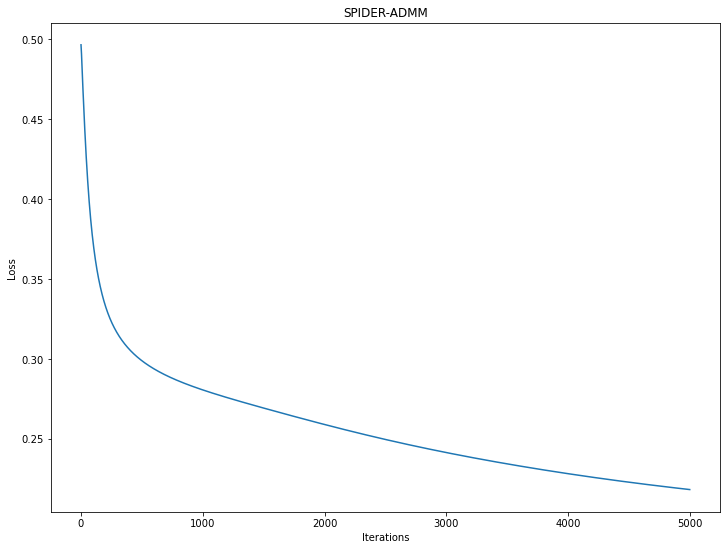

In [97]:
plt.figure(figsize=(12,9))
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SPIDER-ADMM")

In [ ]:
# if we want to use pytorch to calculate the sgd of f(x)
# class f(torch.nn.Module):

In [2]:
def lagrangian(x_k, y_k1, y_j, y_k, z_k): pass

def lagrangian_hat(x, y_k1, z_k, v_k): pass

In [ ]:
def reg_vk(k, q, ...):
    # use some sgd library?
    if k % q == 0:
        vk = ...
    else:
        vk = ...

    return vk

# implement later
# def online_vk(k, q, ...):
#     if k % q == 0:
#         vk = ...
#     else:
#         vk = ...

#     return vk

In [ ]:
# Let b1 = None unless performing online algo (rename if necessary)
def spider_admm(b1, b2, q, K, n, p):
    # init
    x_k = ...
    j = ...
    y_k = ...
    z_k = ...
    
    for k in range(K):
        if b1 is None: 
            vk = reg_vk(k, q, ...)
        else: 
            # implement later
            # vk = online_vk(k, q, ...)
        
        # update k + 1 for y, x, z
        # probably do not need separate k + 1 variables

        # using lagrangian
        lagrs = []
        for j in range(m):
            y_k[j] = np.argmin(...)

        # using lagrangian hat
        lagr_hats = []
        x_k = np.argmin(...)

        z_k = ...

    return [x_k, y_k, z_k]

def online_spider_admm(b1, b2, q, K, n, p): 
    return spider_admm(b1, b2, q, K, n, p)